<a href="https://colab.research.google.com/github/zhanglix/atari_games/blob/master/gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install gym gym[atari] pyvirtualdisplay > /dev/null 2>&1
# !apt update > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# from google.colab import drive
# drive.mount('/content/drive')
# !ls drive
# !mkdir 'drive/My Drive/gym_model'
# !ln -s 'drive/My Drive/gym_model' model

In [0]:
import gym
from gym.wrappers import Monitor
gym.logger.set_level(gym.logger.INFO) 

import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from unittest.mock import MagicMock


In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 200))
display.start();

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = sorted(glob.glob('video/*.mp4'))
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    gym.logger.debug('show video: path=%s', mp4)

    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                 controls >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env, directory='./video', fake_reset=False):
  wenv = Monitor(env, directory, force=True)
  if fake_reset:
        wenv._before_reset()
        wenv._after_reset(None)
  return wenv

def safe_close(wenv):
    mock = MagicMock()
    mock.spec = wenv.env.spec
    wenv.env = mock
    wenv.close()

In [6]:
env = gym.make('Seaquest-v0')
wenv = wrap_env(env)
observation = wenv.reset()

for _ in range(10):
    observation, reward, done, info = wenv.step(env.action_space.sample())
    wenv.render()

safe_close(wenv)
show_video()

INFO: Making new env: Seaquest-v0
INFO: Creating monitor directory ./video
INFO: Starting new video recorder writing to /content/video/openaigym.video.0.123.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


In [7]:
wenv = wrap_env(env, fake_reset=True)
for _ in range(10):
    observation, reward, done, info = wenv.step(env.action_space.sample())
    wenv.render()

safe_close(wenv)
show_video()

INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/video/openaigym.video.1.123.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


In [8]:
env = gym.make('Seaquest-v0')
observation = env.reset()
print(observation.shape)

INFO: Making new env: Seaquest-v0
(210, 160, 3)


In [0]:
def crop_image(img, start=20, height=160):
    return img[start:start+160]

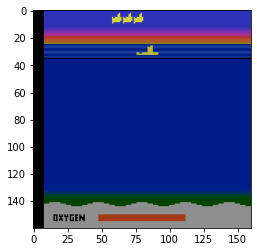

In [10]:
plt.imshow(crop_image(observation))

In [11]:
action_size = env.action_space.n
print(action_size)

18


In [0]:
def add_lstm_layer(input, units, initial_states, final_states, **kwargs):
    initial_memory_state = tf.keras.Input(shape=[units])
    initial_carry_state = tf.keras.Input(shape=[units])
    initial_state = [initial_memory_state, initial_carry_state]
    lstm = tf.keras.layers.LSTM(units, stateful=False, return_state=True, return_sequences=True,**kwargs)
    output, final_memory_state, final_carry_state = lstm(input, initial_state=initial_state)
    final_state =  [final_memory_state, final_carry_state]
    initial_states.append(initial_state)
    final_states.append(final_state)
    return output

def get_base_model(inputs, **kwargs):
    initail_states = []
    final_states = []
    x = tf.keras.layers.Conv2D(8, 3, strides=(2, 2), activation='relu', **kwargs)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), activation='relu', **kwargs)(x)
    x = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), activation='relu', **kwargs)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 0),name='to_sequence')(x)
    x = add_lstm_layer(x, 128, initail_states, final_states, **kwargs)
    x = add_lstm_layer(x, 128, initail_states, final_states, **kwargs)
    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0),name='to_batch')(x)
    feature = tf.keras.layers.Dense(64, activation='relu', name="base_feature", **kwargs)(x)
    return tf.keras.Model(inputs =[inputs, initail_states], outputs=[feature, final_states])
        
    

In [0]:
class EntropyRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, scale=0.1, from_logits=True):
        self.scale=scale
        self.from_logits=from_logits
    def __call__(self, x):
        entropy = tf.keras.losses.categorical_crossentropy(x, x, from_logits=self.from_logits)
        return self.scale * tf.math.reduce_sum(entropy)
        

In [0]:
def get_action_model(action_size, **regularizers):
    screen = tf.keras.Input(shape=(160,160,3), name="screen")
    base_model = get_base_model(screen, **regularizers)
    logits = tf.keras.layers.Dense(action_size, name="logits", 
                                   activity_regularizer=EntropyRegularizer(),
                                   **regularizers)(base_model.output[0])
    action = tf.keras.layers.Lambda(lambda x: tf.random.categorical(x, 1), name='action')(logits)
    return tf.keras.Model(inputs = base_model.input, outputs=[action, base_model.output[1]], name="action")


In [0]:
def get_a3c_model(action_size, **regularizers):
    action_model = get_action_model(action_size, **regularizers)
    return get_a3c_model_from_action(action_model, **regularizers)
    
def get_a3c_model_from_action(action_model, **regularizers):
    feature = action_model.get_layer(name="base_feature").output
    score = tf.keras.layers.Dense(1, name="state_score",**regularizers)(feature)
    outputs = [action_model.output[0], score, action_model.output[1]]
    return tf.keras.Model(inputs = action_model.input, outputs=outputs)

In [0]:
class SparseCategorialCrossEntropy(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.losses.sparse_categorical_crossentropy(inputs[0], inputs[1], from_logits=True)

    

In [0]:
def get_train_model_from(a3c_model):
    target_score = tf.keras.Input(shape=(1,), name="target_score")
    sample_action = tf.keras.Input(shape=(1,), dtype=tf.int32, name="sample_action")
    state_score = a3c_model.get_layer(name="state_score").output
    logits = a3c_model.get_layer(name="logits").output
    cross_entropy=SparseCategorialCrossEntropy(name="logits_cross_entrofy")([sample_action, logits])
    action_gain = tf.keras.layers.Subtract(name="action_gain", 
                                           activity_regularizer=lambda x: tf.math.reduce_sum(tf.math.square(x)))
    action_gain = action_gain([target_score, state_score])
    action_loss = tf.keras.layers.Multiply(name="action_loss",
                                           activity_regularizer=tf.math.reduce_sum)
    action_loss = action_loss([cross_entropy, action_gain])
    return tf.keras.Model(inputs= [a3c_model.input, sample_action, target_score],
                          outputs = action_loss)

In [0]:
a3c_model = get_a3c_model(action_size, kernel_regularizer="l1_l2", bias_regularizer="l1_l2")
train_model =  get_train_model_from(a3c_model)

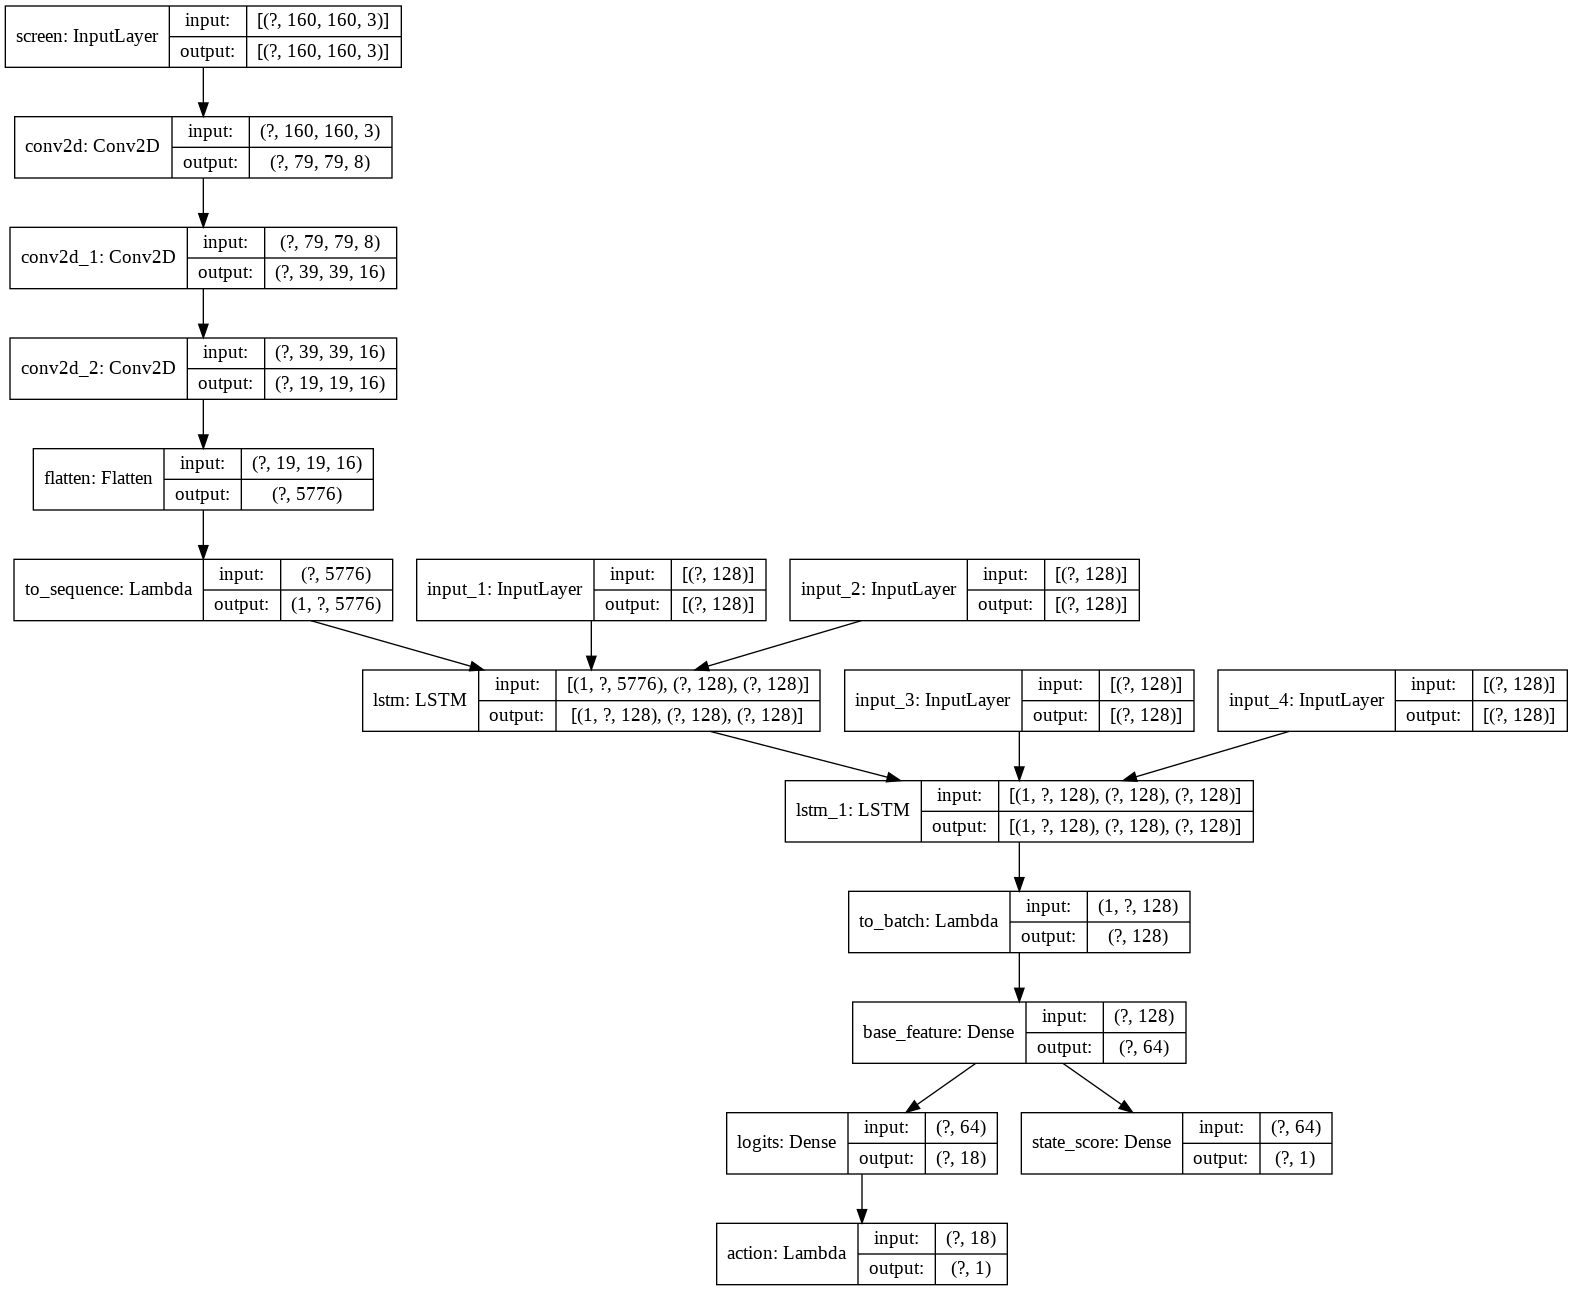

In [19]:
tf.keras.utils.plot_model(a3c_model, show_shapes=True)

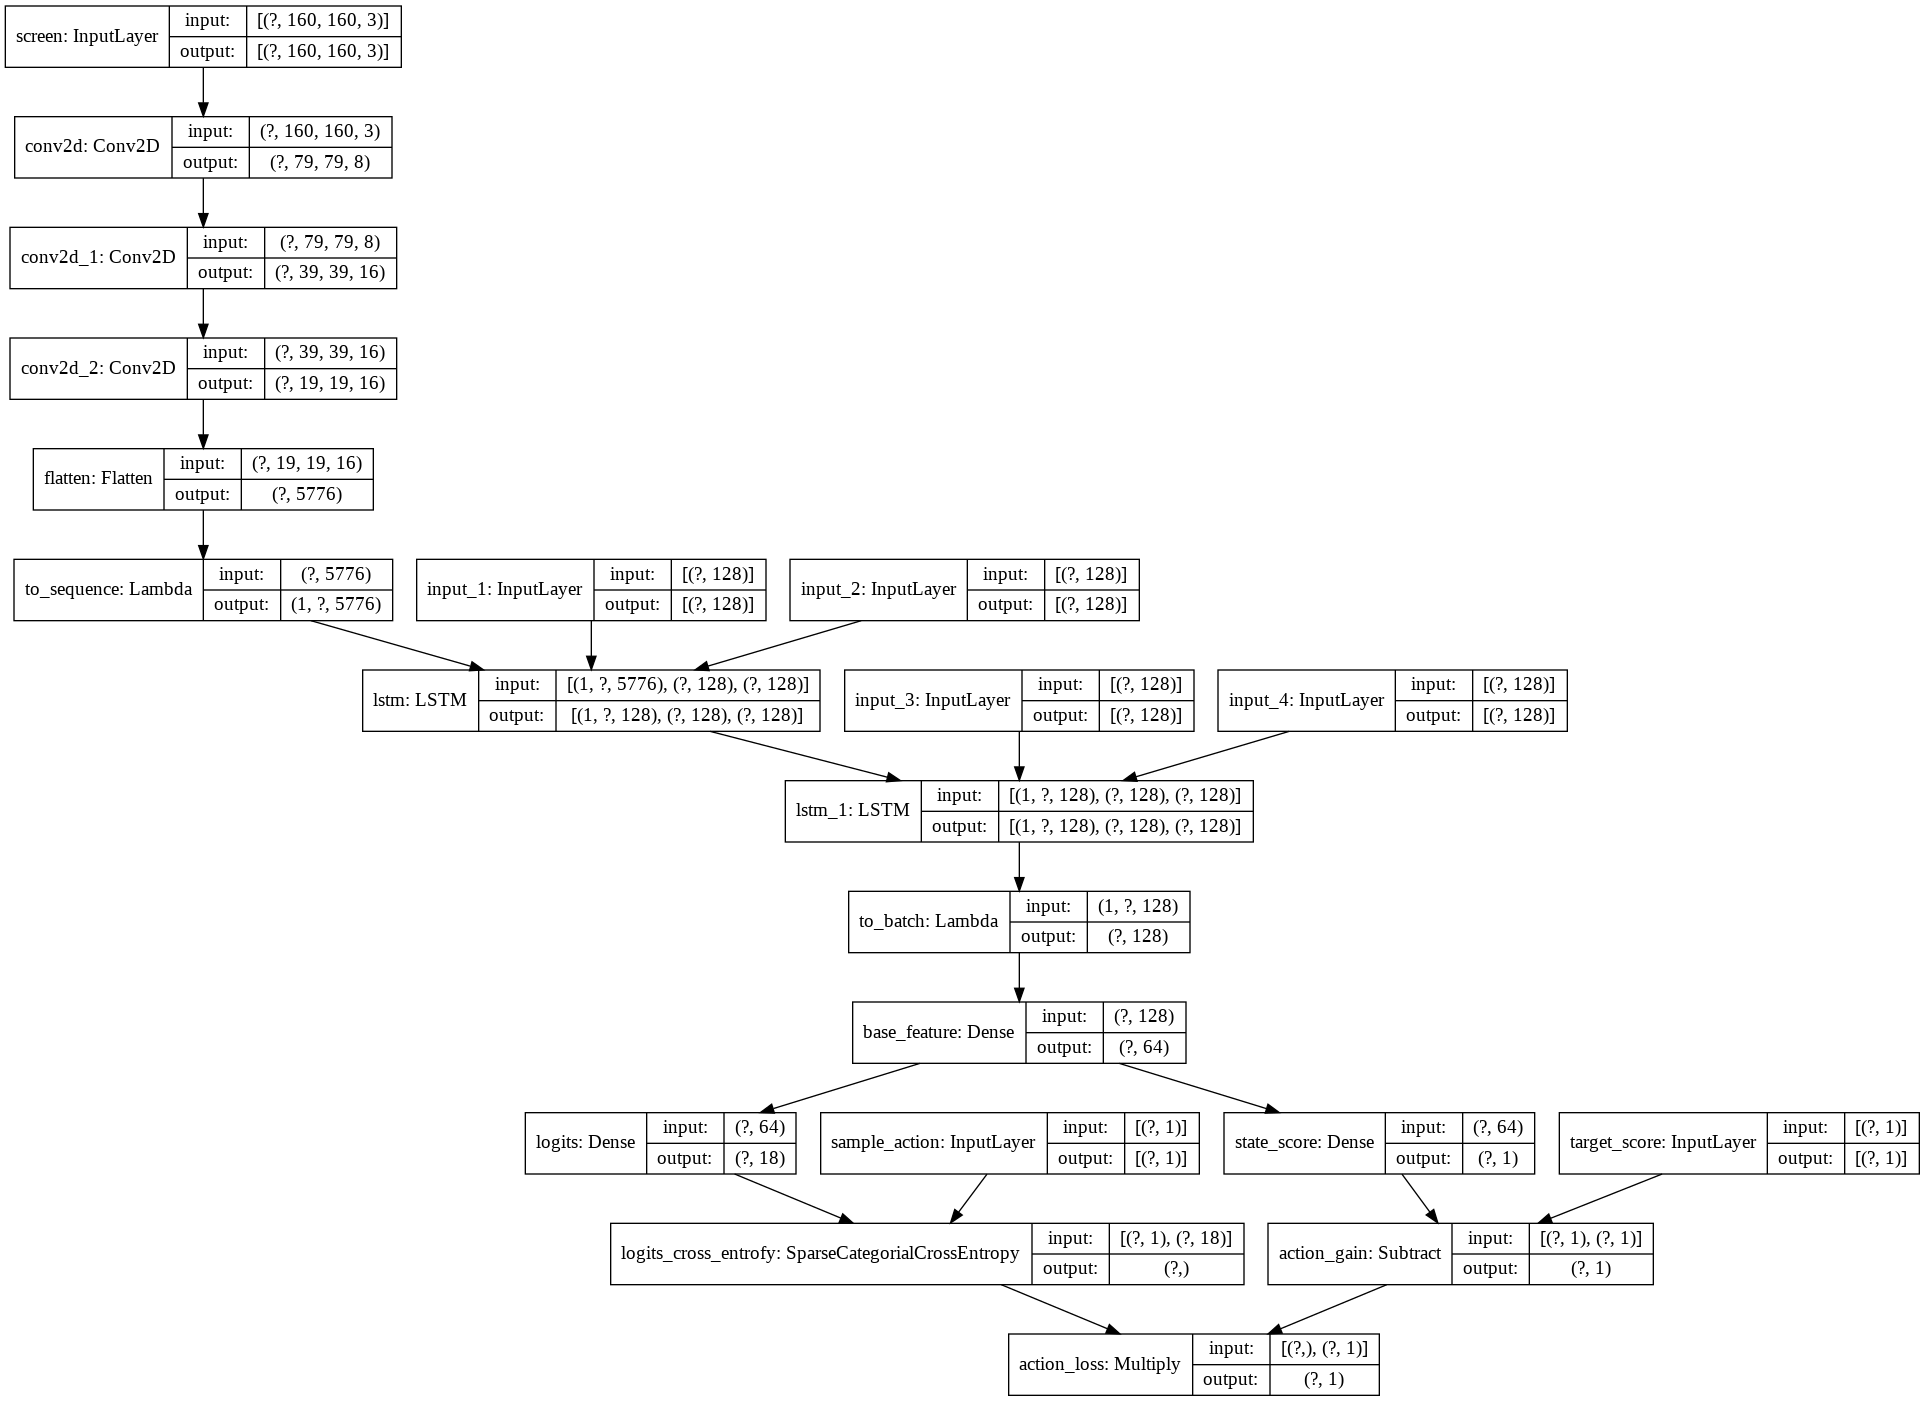

In [20]:
tf.keras.utils.plot_model(train_model, show_shapes=True)

In [0]:
# "input:", a3c_model.input,"output:", a3c_model.output

In [0]:
# "input:", train_model.input,"output:", train_model.output

In [0]:
# train_model.losses, len(train_model.losses)

In [0]:
def get_zero_state(state, batch_size = 1):
    if type(state) == list:
        return [get_zero_state(x) for x in state]
    if type(state) == tf.Tensor:
        shape = state.shape.as_list()
        shape[0] = batch_size
        return tf.zeros(shape, dtype=state.dtype)
    raise ValueError("state is not a valid type")
    


In [0]:
def observation_to_screen(observation, start_row):
    return crop_image(observation, start=start_row)/np.float32(255)
    
def play(model, env, initial_state = None, max_step=6000, render=False, record=False, start_row=20):
    screens = []
    actions = []
    rewards = []

    if initial_state != None:
        gym.logger.debug("resumming play")
        score, done, observation, model_state = initial_state
    else:
        gym.logger.debug("new play")
        score = 0
        done = False
        observation = env.reset()
        model_state = get_zero_state(model.input[1])
    if score < 0:
        gym.logger.error("got score: {} is negative.".format(score))

    for t in range(max_step):
        if render:
            env.render()            
        screen = observation_to_screen(observation, start_row)        
        action, _, model_state = model([tf.constant([screen]), model_state])
        action = action[0][0].numpy()
        observation, reward, done, info = env.step(action)     
        if reward < 0:
            gym.logger.error("step reward: {} is negative. current_score:{}".format(reward, score))
        score += reward       
        if record:
            screens.append(screen)
            actions.append([action])
            rewards.append([reward])
        if done:
            break
    gym.logger.debug("finished with score: {} after {} timesteps".format(score, t+1))
    return [score, done, observation, model_state], [tf.constant(screens), tf.constant(actions), tf.constant(rewards)]

In [37]:
def evaluate(model, env, initial_state = None, **kwargs):
    fake_reset = initial_state != None
    gym.logger.debug("fake reset: {}".format(fake_reset))
    env = wrap_env(env, fake_reset= fake_reset)
    state, _ = play(model, env, render=True, record=False, initial_state=initial_state, **kwargs)
    gym.logger.info("Evaluation finished with score:{}".format{state[0]})
    safe_close(env)
    show_video()
    return state

def record_play(model, env, **kwargs)    :
    return play(model, env, render=False, record=True, **kwargs)

SyntaxError: ignored

In [0]:
def estimate_score(rewards, last=0, future_discount=0.99):
    scores = []
    for r in reversed(rewards):
        last = last + r
        scores.insert(0,last)
        last *= future_discount
    scores = tf.stack(scores)
    return scores


In [0]:
def train_one_episode(env, a3c_model, train_model, optimizer, batch_size=64, start_row=20):
    
    record_state = None
    initial_train_state = get_zero_state(a3c_model.input[1])
    done = False
    batch = 0
    while not done:
        record_state, [screens, actions, rewards] = record_play(a3c_model, env,                                                          
                                                                initial_state = record_state,
                                                                start_row=start_row,
                                                                max_step=batch_size)
        score, done, observation, model_state = record_state
        if not done:
            screen = observation_to_screen(observation, start_row)
            _, state_score, _= a3c_model([tf.constant([screen]), model_state])
            last = state_score[0][0]
        else:
            last = 0
        target_score = estimate_score(rewards, last)
        train_model_input = [[screens, initial_train_state], actions, target_score]
        with tf.GradientTape() as tape:
            out = train_model(train_model_input)
            loss_value = tf.reduce_sum(train_model.losses)
        grads = tape.gradient(loss_value, train_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, train_model.trainable_weights))    
        initial_train_state = model_state
        batch += 1
        if batch % 10 == 0:
            gym.logger.info("training score:{} at batch:{}".format(score, batch))
    gym.logger.info("training episode finished with score:{} at batch:{}".format(score, batch))
            
    

In [33]:
state = evaluate(a3c_model, env, max_step=6000)

INFO: Clearing 2 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/video/openaigym.video.3.123.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


In [0]:
optimizer = tf.keras.optimizers.RMSprop()

In [35]:
train_one_episode(env, a3c_model, train_model, optimizer)

INFO: training score:60.0 at batch:10
INFO: training episode finished with score:140.0 at step:17


In [36]:
state = evaluate(a3c_model, env, max_step=6000)

INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/video/openaigym.video.4.123.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


'My Drive'


openaigym.episode_batch.4.123.stats.json
openaigym.manifest.4.123.manifest.json
openaigym.video.4.123.video000000.meta.json
openaigym.video.4.123.video000000.mp4
